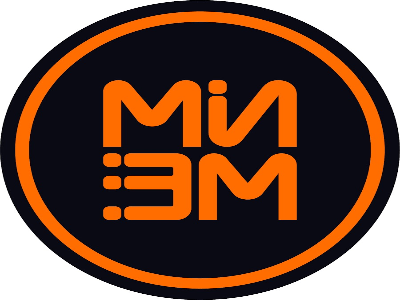

In [ ]:
from IPython import get_ipython
from IPython.display import display
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image = cv2.imread('miem.jpg')
image = cv2.resize(image, (400, 300))

if image is None:
    print("Не удалось загрузить изображение")
else:
    height, width = image.shape[:2]

    M = np.float32([[1, 0, 0], [0.5, 1, -100]])

    transformed_image = cv2.warpAffine(image, M, (width, height))

    cv2_imshow(image)

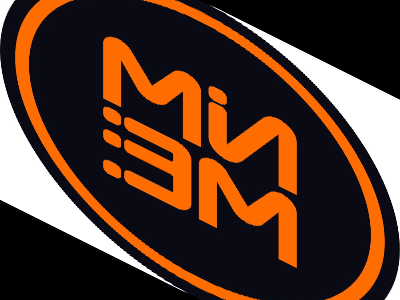

In [ ]:
cv2_imshow(transformed_image)

In [ ]:
def detect_and_draw_keypoints(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    orb = cv2.ORB_create()
    fast = cv2.FastFeatureDetector_create()

    kp1, des1 = sift.detectAndCompute(gray_image, None)
    kp2, des2 = orb.detectAndCompute(gray_image, None)
    kp3 = fast.detect(image, None)
    orb_fast = cv2.ORB_create()
    kp3, des3 = orb_fast.compute(image, kp3)

    image_sift = cv2.drawKeypoints(image, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_orb = cv2.drawKeypoints(image, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    image_fast = cv2.drawKeypoints(image, kp3, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return image_sift, image_orb, image_fast, kp1, kp2, kp3, des1, des2, des3


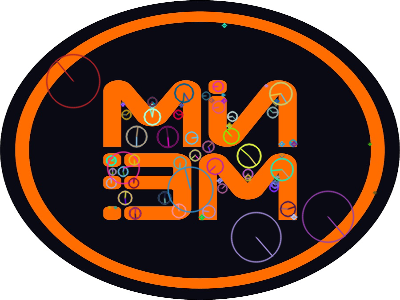

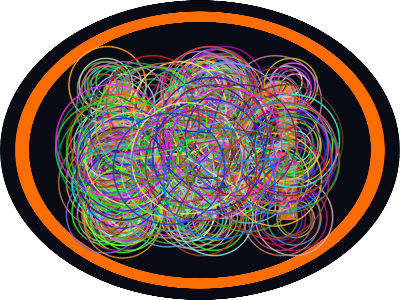

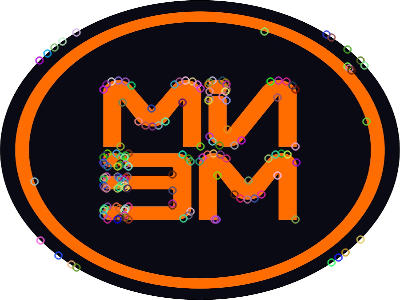

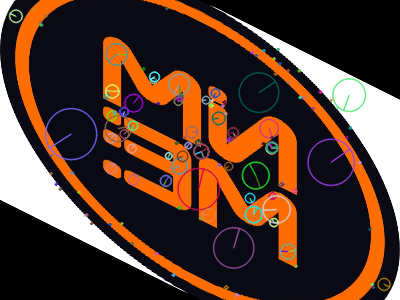

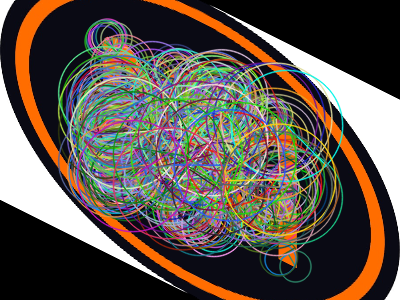

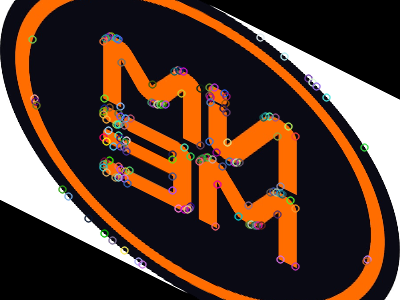

In [ ]:
    im_untouched_sift, im_untouched_orb, im_untouched_fast, kp1, kp2, kp3, des1, des2, des3 = detect_and_draw_keypoints(image)
    im_transformed_sift, im_transformed_orb, im_transformed_fast, kp1_transformed, kp2_transformed, kp3_transformed, des1_transformed, des2_transformed, des3_transformed = detect_and_draw_keypoints(transformed_image)

    cv2_imshow(im_untouched_sift)
    cv2_imshow(im_untouched_orb)
    cv2_imshow(im_untouched_fast)

    cv2_imshow(im_transformed_sift)
    cv2_imshow(im_transformed_orb)
    cv2_imshow(im_transformed_fast)

In [ ]:
def match_keypoints(image1, image2, kp1, kp2, des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    matched_image = cv2.drawMatches(image1, kp1, image2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return matched_image, matches

In [ ]:
im_sift_matches, matches_sift = match_keypoints(image, transformed_image, kp1, kp1_transformed, des1, des1_transformed)
im_orb_matches, matches_orb = match_keypoints(image, transformed_image, kp2, kp2_transformed, des2, des2_transformed)
im_fast_matches, matches_fast = match_keypoints(image, transformed_image, kp3, kp3_transformed, des3, des3_transformed)


In [ ]:
print(f"Сколько точек нашел SIFT: {len(kp1)}")
print(f"Сколько точек нашел ORB: {len(kp2)}")
print(f"Сколько точек нашел FAST: {len(kp3)}")

print(f"Сколько точек после BFMatcher (SIFT): {len(matches_sift)}")
print(f"Сколько точек после BFMatcher (ORB): {len(matches_orb)}")
print(f"Сколько точек после BFMatcher (FAST + ORB): {len(matches_fast)}")

Сколько точек нашел SIFT: 111
Сколько точек нашел ORB: 498
Сколько точек нашел FAST: 156
Сколько точек после BFMatcher (SIFT): 47
Сколько точек после BFMatcher (ORB): 170
Сколько точек после BFMatcher (FAST + ORB): 40


In [ ]:
def match_with_ransac(image1, image2, kp1, kp2, des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    matched_image_ransac = cv2.drawMatches(image1, kp1, image2, kp2, matches, None, matchesMask=matchesMask, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return matched_image_ransac, matches, matchesMask, M

In [ ]:
im_sift_ransac, matches_sift_ransac, mask_sift, M_sift = match_with_ransac(image, transformed_image, kp1, kp1_transformed, des1, des1_transformed)
im_orb_ransac, matches_orb_ransac, mask_orb, M_orb = match_with_ransac(image, transformed_image, kp2, kp2_transformed, des2, des2_transformed)
im_fast_ransac, matches_fast_ransac, mask_fast, M_fast = match_with_ransac(image, transformed_image, kp3, kp3_transformed, des3, des3_transformed)
print(f"Сколько точек после RANSAC (SIFT): {sum(mask_sift)}")
print(f"Сколько точек после RANSAC (ORB): {sum(mask_orb)}")
print(f"Сколько точек после RANSAC (FAST + ORB): {sum(mask_fast)}")
print(f"Ошибка в оценивании параметров преобразования (SIFT): {np.abs(M_sift[0, 0] - 1) + np.abs(M_sift[1, 1] - 1)}")
print(f"Ошибка в оценивании параметров преобразования (ORB): {np.abs(M_orb[0, 0] - 1) + np.abs(M_orb[1, 1] - 1)}")
print(f"Ошибка в оценивании параметров преобразования (FAST + ORB): {np.abs(M_fast[0, 0] - 1) + np.abs(M_fast[1, 1] - 1)}")
print("Норма BFMatcher для 3го алгоритма (FAST + ORB): NORM_L2")

Сколько точек после RANSAC (SIFT): 22
Сколько точек после RANSAC (ORB): 55
Сколько точек после RANSAC (FAST + ORB): 20
Ошибка в оценивании параметров преобразования (SIFT): 0.023547275328846817
Ошибка в оценивании параметров преобразования (ORB): 0.05928168710263648
Ошибка в оценивании параметров преобразования (FAST + ORB): 0.03959676177357219
Норма BFMatcher для 3го алгоритма (FAST + ORB): NORM_L2


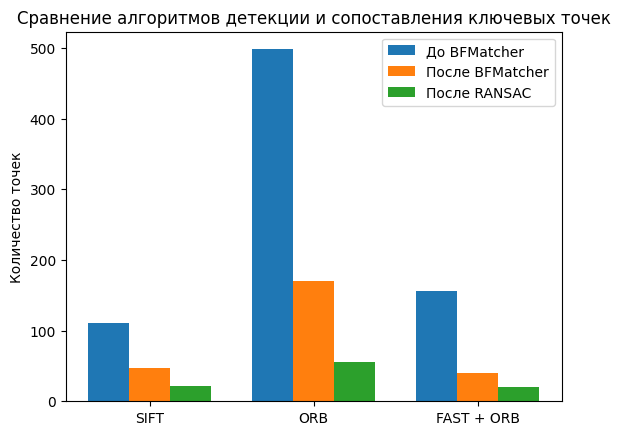

In [ ]:
import matplotlib.pyplot as plt
algorithms = ['SIFT', 'ORB', 'FAST + ORB']
before_bfmatcher = [len(kp1), len(kp2), len(kp3)]
after_bfmatcher = [len(matches_sift), len(matches_orb), len(matches_fast)]
after_ransac = [sum(mask_sift), sum(mask_orb), sum(mask_fast)]

x = np.arange(len(algorithms))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, before_bfmatcher, width, label='До BFMatcher')
ax.bar(x, after_bfmatcher, width, label='После BFMatcher')
ax.bar(x + width, after_ransac, width, label='После RANSAC')

ax.set_ylabel('Количество точек')
ax.set_title('Сравнение алгоритмов детекции и сопоставления ключевых точек')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

plt.show()